In [1]:
import os
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm
import json
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2

In [2]:
image_size = (512, 512)

In [3]:
mhd_info_csv_path = "data/mhd_info.csv"
mhd_info_df = pd.read_csv(mhd_info_csv_path)
mhd_info_df.head()

,mhd_file_path,mask_file_path,subset_id,series_id,total_images,origins,spacings,is_flip,ct_image_folder
0,../downloads/data/subset0/1.3.6.1.4.1.14519.5....,../downloads/seg-lungs-LUNA16/1.3.6.1.4.1.1451...,0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,121,"[-335.209991, -195.0, -198.100006]","[2.5, 0.7617189884185791, 0.7617189884185791]",False,../data/images/1.3.6.1.4.1.14519.5.2.1.6279.60...
1,../downloads/data/subset0/1.3.6.1.4.1.14519.5....,../downloads/seg-lungs-LUNA16/1.3.6.1.4.1.1451...,0,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,119,"[-313.75, -190.0, -182.5]","[2.5, 0.7421879768371582, 0.7421879768371582]",False,../data/images/1.3.6.1.4.1.14519.5.2.1.6279.60...
2,../downloads/data/subset0/1.3.6.1.4.1.14519.5....,../downloads/seg-lungs-LUNA16/1.3.6.1.4.1.1451...,0,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,161,"[-194.0, -108.300003, -187.699997]","[1.25, 0.5488280057907104, 0.5488280057907104]",False,../data/images/1.3.6.1.4.1.14519.5.2.1.6279.60...
3,../downloads/data/subset0/1.3.6.1.4.1.14519.5....,../downloads/seg-lungs-LUNA16/1.3.6.1.4.1.1451...,0,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,538,"[-298.774994, -143.100006, -180.600006]","[0.625, 0.7421879768371582, 0.7421879768371582]",False,../data/images/1.3.6.1.4.1.14519.5.2.1.6279.60...
4,../downloads/data/subset0/1.3.6.1.4.1.14519.5....,../downloads/seg-lungs-LUNA16/1.3.6.1.4.1.1451...,0,1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896...,124,"[-337.480011, -157.5, -166.399994]","[2.5, 0.6152340173721313, 0.6152340173721313]",False,../data/images/1.3.6.1.4.1.14519.5.2.1.6279.60...


In [4]:
annotations_included_path = "data/annotations.csv"
annotations_included_df = pd.read_csv(annotations_included_path, delimiter=",")
annotations_included_df["included"] = 1
annotations_included_df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,included
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,1
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,1
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,1
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,1


In [5]:
annotations_excluded_path = "data/annotations_excluded.csv"
annotations_excluded_df = pd.read_csv(annotations_excluded_path, delimiter=",")
annotations_excluded_df["included"] = 0
annotations_excluded_df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,included
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-131.896494,-155.056702,-317.8,-1.0,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,80.798736,-109.295001,-123.4,-1.0,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-62.287146,-55.154396,-283.6,-1.0,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,83.376859,-58.377052,-236.8,-1.0,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-41.017623,-60.310645,-240.4,-1.0,0


In [6]:
annotations = pd.concat([annotations_included_df, annotations_excluded_df])
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,included
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,1
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,1
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,1
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,1


In [7]:
def read_detection_result():
    detection_result_folder = "../output/valresults/caltech/h/off"

    detection_dfs = {}
    for epoch_id in tqdm(os.listdir(detection_result_folder), desc="test epoch"):
        current_folder_path = "{}/{}".format(detection_result_folder, epoch_id)

        detection_dfs.setdefault(epoch_id, {})
        for filename in os.listdir(current_folder_path):
            series_id = filename[0:-4]
            file = os.path.join(current_folder_path, filename)
            try:
                result_df = pd.read_csv(file, delimiter=" ", header=None)
                result_df.columns = ["z-index", "top_left_x", "top_left_y", "width", "height", "probability"]
                detection_dfs.get(epoch_id).setdefault(series_id, result_df)
            except Exception:
                # print(epoch_id, filename, "skipped")
                empty_df = pd.DataFrame()
                detection_dfs.get(epoch_id).setdefault(series_id, empty_df)

    return detection_dfs

test_detections = read_detection_result()

test epoch: 100%|██████████| 150/150 [00:16<00:00,  9.32it/s]


In [8]:
test_detections.keys()

dict_keys(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '1

In [9]:
def is_nodule_included(n):
    return n["included"] == 1

In [13]:
sensitivity_x = []
sensitivity_y = []
for epoch_id in tqdm(list(test_detections.keys())[100:]):
# for epoch_id in ["009"]:
    epoch_candidates = test_detections[epoch_id]

    total_number_of_candidates = 0
    total_number_of_nodules = 0
    irrelevant_candidates = 0

    double_candidates_ignored = 0

    tp = 0
    fp = 0
    fn = 0
    tn = 0

    min_probability = -1

    froc_gts = []
    froc_probs = []

    fp_divisors = []
    exclude_list = []

    ignored_candidates = []

    series_ids = epoch_candidates.keys()

    for series_id in tqdm(series_ids, desc="series_id"):
        mhd_info = mhd_info_df[mhd_info_df["series_id"] == series_id].iloc[0]
        origins = mhd_info["origins"]
        spacings = mhd_info["spacings"]
        is_flip = mhd_info["is_flip"]

        spacings = json.loads(spacings)
        origins = json.loads(origins)

        [z_spacing, y_spacing, x_spacing] = spacings
        [z_origin, y_origin, x_origin] = origins

        candidates = epoch_candidates[series_id].reset_index()
        candidates2 = candidates.copy()
        total_number_of_candidates = len(candidates)

        nodules = annotations[annotations["seriesuid"] == series_id]

        for _, nodule in nodules.iterrows():
            if is_nodule_included(nodule):
                total_number_of_nodules += 1

            x = nodule["coordX"]
            y = nodule["coordY"]
            z = nodule["coordZ"]
            diameter = nodule["diameter_mm"]

            if diameter <= 0:
                diameter = 10

            radius_squared = pow((diameter / 2), 2)

            matched_candidates = []

            for candidate_id, candidate in candidates.iterrows():
                x2 = candidate["top_left_x"]
                y2 = candidate["top_left_y"]
                z2 = candidate["z-index"]

                if is_flip:
                    x2 = image_size[0] - x2
                    y2 = image_size[1] - y2

                x2 = x2 * x_spacing + x_origin
                y2 = y2 * y_spacing + y_origin
                z2 = z2 * z_spacing + z_origin

                dist = pow(x - x2, 2) + pow(y - y2, 2) + pow(z - z2, 2)
                if dist < radius_squared:
                    if is_nodule_included(nodule):
                        matched_candidates.append(candidate)
                        if candidate_id not in candidates2.index.values:
                            print(candidate, nodule)
                        else:
                            candidates2.drop([candidate_id])
                    else:
                        if candidate_id in candidates2.index.values:
                            irrelevant_candidates += 1
                            ignored_candidates.append(nodule)
                            candidates2.drop([candidate_id])

            if len(matched_candidates) > 1:
                double_candidates_ignored += (len(matched_candidates) - 1)

            if is_nodule_included(nodule):
                if len(matched_candidates) > 0:
                    max_probability = min_probability
                    for candidate in matched_candidates:
                        max_probability = max(max_probability, candidate["probability"])

                    froc_gts.append(1)
                    froc_probs.append(max_probability)
                    fp_divisors.append(series_id)
                    exclude_list.append(False)
                    tp += 1
                else:
                    fn += 1
                    froc_gts.append(1)
                    froc_probs.append(min_probability)
                    fp_divisors.append(series_id)
                    exclude_list.append(True)

        for _, candidate3 in candidates2.iterrows():
            fp += 1
            froc_gts.append(0)
            froc_probs.append(candidate3["probability"])
            fp_divisors.append(series_id)
            exclude_list.append(False)

    print("tp", tp)
    print("fp", fp)
    print("fn", fn)
    print("tn", tn)

    print("total number of candidates", total_number_of_candidates)
    print("total number of nodules", total_number_of_nodules)

    print("irrelevant candidates", irrelevant_candidates)
    print("Ignored candidates which were double detections on a nodule", double_candidates_ignored)

    sensitivity_x.append(epoch_id)
    if total_number_of_nodules == 0:
        print("sensitivity", 0)
        sensitivity_y.append(0)
    else:
        print("sensitivity", tp / total_number_of_nodules)
        sensitivity_y.append(tp / total_number_of_nodules)

    print("Average number of candidates per scan", total_number_of_candidates / len(series_ids))

    # y = []
    # y_prob = []
    #
    # for i in range(len(exclude_list)):
    #     y.append(froc_gts[i])
    #     y_prob.append(froc_probs[i])

    # fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)

    # #create ROC curve
    # plt.plot(fpr, tpr)
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()


  2%|▏         | 1/50 [00:01<01:26,  1.76s/it]

tp 6
fp 441
fn 99
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 84
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.11864406779661017



  4%|▍         | 2/50 [00:03<01:23,  1.75s/it]

tp 6
fp 440
fn 99
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 88
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.11864406779661017



  6%|▌         | 3/50 [00:05<01:21,  1.74s/it]

tp 6
fp 410
fn 99
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 87
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.1016949152542373



  8%|▊         | 4/50 [00:06<01:18,  1.72s/it]

tp 7
fp 405
fn 98
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 87
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.1016949152542373



 10%|█         | 5/50 [00:08<01:16,  1.70s/it]

tp 6
fp 400
fn 99
tn 0
total number of candidates 5
total number of nodules 105
irrelevant candidates 80
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.0847457627118644



 12%|█▏        | 6/50 [00:10<01:16,  1.74s/it]

tp 7
fp 426
fn 98
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 84
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.06779661016949153



 14%|█▍        | 7/50 [00:12<01:15,  1.76s/it]

tp 9
fp 429
fn 96
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 91
Ignored candidates which were double detections on a nodule 1
sensitivity 0.08571428571428572
Average number of candidates per scan 0.06779661016949153



 16%|█▌        | 8/50 [00:13<01:14,  1.77s/it]

tp 9
fp 455
fn 96
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 90
Ignored candidates which were double detections on a nodule 1
sensitivity 0.08571428571428572
Average number of candidates per scan 0.1016949152542373



 18%|█▊        | 9/50 [00:15<01:11,  1.75s/it]

tp 8
fp 423
fn 97
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 94
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.1016949152542373



 20%|██        | 10/50 [00:17<01:09,  1.73s/it]

tp 8
fp 402
fn 97
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 88
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.11864406779661017



 22%|██▏       | 11/50 [00:18<01:05,  1.68s/it]

tp 7
fp 386
fn 98
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 83
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.11864406779661017



 24%|██▍       | 12/50 [00:20<01:01,  1.63s/it]

tp 7
fp 353
fn 98
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 88
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.1016949152542373



 26%|██▌       | 13/50 [00:21<00:59,  1.60s/it]

tp 8
fp 348
fn 97
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 77
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.1016949152542373



 28%|██▊       | 14/50 [00:23<00:57,  1.61s/it]

tp 8
fp 383
fn 97
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 84
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.11864406779661017



 30%|███       | 15/50 [00:25<00:54,  1.56s/it]

tp 9
fp 356
fn 96
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 85
Ignored candidates which were double detections on a nodule 1
sensitivity 0.08571428571428572
Average number of candidates per scan 0.1016949152542373



 32%|███▏      | 16/50 [00:26<00:52,  1.53s/it]

tp 8
fp 344
fn 97
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 77
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.1016949152542373



 34%|███▍      | 17/50 [00:27<00:49,  1.51s/it]

tp 7
fp 329
fn 98
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 75
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.1016949152542373



 36%|███▌      | 18/50 [00:29<00:47,  1.49s/it]

tp 7
fp 338
fn 98
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 74
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.11864406779661017



 38%|███▊      | 19/50 [00:31<00:47,  1.53s/it]

tp 7
fp 406
fn 98
tn 0
total number of candidates 10
total number of nodules 105
irrelevant candidates 86
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.1694915254237288



 40%|████      | 20/50 [00:32<00:47,  1.57s/it]

tp 9
fp 423
fn 96
tn 0
total number of candidates 9
total number of nodules 105
irrelevant candidates 91
Ignored candidates which were double detections on a nodule 1
sensitivity 0.08571428571428572
Average number of candidates per scan 0.15254237288135594



 42%|████▏     | 21/50 [00:34<00:47,  1.62s/it]

tp 8
fp 434
fn 97
tn 0
total number of candidates 8
total number of nodules 105
irrelevant candidates 90
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.13559322033898305



 44%|████▍     | 22/50 [00:36<00:45,  1.63s/it]

tp 8
fp 413
fn 97
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 86
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.11864406779661017



 46%|████▌     | 23/50 [00:37<00:43,  1.62s/it]

tp 7
fp 379
fn 98
tn 0
total number of candidates 5
total number of nodules 105
irrelevant candidates 74
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.0847457627118644



 48%|████▊     | 24/50 [00:39<00:42,  1.62s/it]

tp 6
fp 372
fn 99
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 73
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.11864406779661017



 50%|█████     | 25/50 [00:40<00:40,  1.60s/it]

tp 7
fp 356
fn 98
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 75
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.1016949152542373



 52%|█████▏    | 26/50 [00:42<00:37,  1.58s/it]

tp 7
fp 359
fn 98
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 71
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.1016949152542373



 54%|█████▍    | 27/50 [00:43<00:35,  1.54s/it]

tp 6
fp 354
fn 99
tn 0
total number of candidates 7
total number of nodules 105
irrelevant candidates 65
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.11864406779661017



 56%|█████▌    | 28/50 [00:45<00:32,  1.49s/it]

tp 6
fp 312
fn 99
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 62
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.1016949152542373



 58%|█████▊    | 29/50 [00:46<00:30,  1.44s/it]

tp 7
fp 301
fn 98
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 62
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.06779661016949153



 60%|██████    | 30/50 [00:47<00:27,  1.37s/it]

tp 6
fp 276
fn 99
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 56
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.06779661016949153



 62%|██████▏   | 31/50 [00:48<00:25,  1.32s/it]

tp 6
fp 265
fn 99
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 55
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.05084745762711865



 64%|██████▍   | 32/50 [00:50<00:23,  1.32s/it]

tp 8
fp 281
fn 97
tn 0
total number of candidates 5
total number of nodules 105
irrelevant candidates 57
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.0847457627118644



 66%|██████▌   | 33/50 [00:51<00:22,  1.33s/it]

tp 8
fp 285
fn 97
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 62
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.1016949152542373



 68%|██████▊   | 34/50 [00:52<00:21,  1.33s/it]

tp 7
fp 283
fn 98
tn 0
total number of candidates 6
total number of nodules 105
irrelevant candidates 63
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.1016949152542373



 70%|███████   | 35/50 [00:54<00:19,  1.31s/it]

tp 7
fp 295
fn 98
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 64
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.06779661016949153



 72%|███████▏  | 36/50 [00:55<00:18,  1.30s/it]

tp 6
fp 295
fn 99
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 56
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.06779661016949153



 74%|███████▍  | 37/50 [00:56<00:16,  1.30s/it]

tp 6
fp 290
fn 99
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 55
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.06779661016949153



 76%|███████▌  | 38/50 [00:58<00:15,  1.31s/it]

tp 8
fp 304
fn 97
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 65
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0761904761904762
Average number of candidates per scan 0.06779661016949153



 78%|███████▊  | 39/50 [00:59<00:14,  1.31s/it]

tp 7
fp 300
fn 98
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 57
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.06779661016949153



 80%|████████  | 40/50 [01:00<00:12,  1.30s/it]

tp 7
fp 289
fn 98
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 57
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.05084745762711865



 82%|████████▏ | 41/50 [01:01<00:11,  1.28s/it]

tp 6
fp 283
fn 99
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 54
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.05084745762711865



 84%|████████▍ | 42/50 [01:03<00:10,  1.30s/it]

tp 5
fp 309
fn 100
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 54
Ignored candidates which were double detections on a nodule 1
sensitivity 0.047619047619047616
Average number of candidates per scan 0.05084745762711865



 86%|████████▌ | 43/50 [01:04<00:09,  1.33s/it]

tp 6
fp 321
fn 99
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 55
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.05084745762711865



 88%|████████▊ | 44/50 [01:06<00:08,  1.34s/it]

tp 7
fp 318
fn 98
tn 0
total number of candidates 2
total number of nodules 105
irrelevant candidates 57
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.03389830508474576



 90%|█████████ | 45/50 [01:07<00:06,  1.36s/it]

tp 4
fp 325
fn 101
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 49
Ignored candidates which were double detections on a nodule 0
sensitivity 0.0380952380952381
Average number of candidates per scan 0.05084745762711865



 92%|█████████▏| 46/50 [01:08<00:05,  1.38s/it]

tp 4
fp 312
fn 101
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 46
Ignored candidates which were double detections on a nodule 1
sensitivity 0.0380952380952381
Average number of candidates per scan 0.05084745762711865



 94%|█████████▍| 47/50 [01:10<00:04,  1.40s/it]

tp 6
fp 322
fn 99
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 50
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.05084745762711865



 96%|█████████▌| 48/50 [01:11<00:02,  1.42s/it]

tp 6
fp 340
fn 99
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 51
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.06779661016949153



 98%|█████████▊| 49/50 [01:13<00:01,  1.42s/it]

tp 7
fp 332
fn 98
tn 0
total number of candidates 4
total number of nodules 105
irrelevant candidates 54
Ignored candidates which were double detections on a nodule 1
sensitivity 0.06666666666666667
Average number of candidates per scan 0.06779661016949153



100%|██████████| 50/50 [01:14<00:00,  1.49s/it]

tp 6
fp 312
fn 99
tn 0
total number of candidates 3
total number of nodules 105
irrelevant candidates 50
Ignored candidates which were double detections on a nodule 1
sensitivity 0.05714285714285714
Average number of candidates per scan 0.05084745762711865


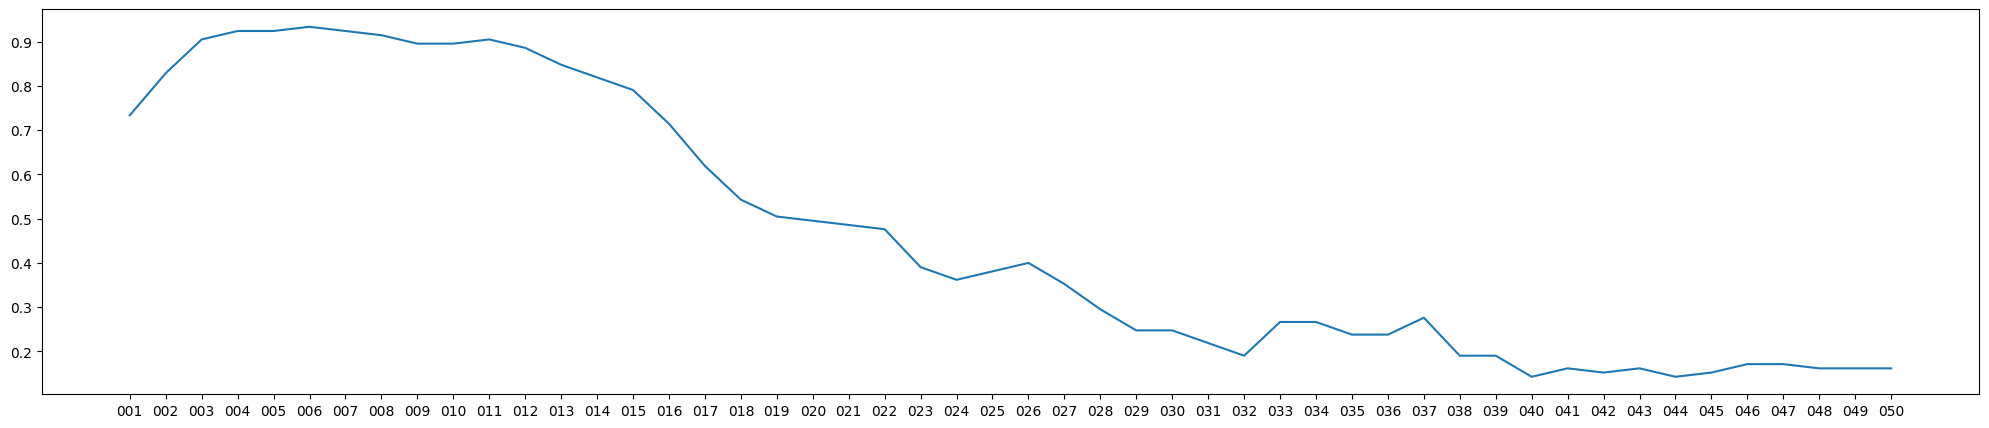

In [11]:
figure(figsize=(25, 5))
plt.plot(sensitivity_x, sensitivity_y, label='Sensitivity')

In [12]:
# 008
# tp 63
# fp 1509505
# fn 42
# tn 0
# total number of candidates 39121
# total number of nodules 105
# irrelevant candidates 25482
# Ignored candidates which were double detections on a nodule 2556
# sensitivity 0.6
# Average number of candidates per scan 444.5568181818182

In [13]:
# 052
# tp 52
# fp 402505
# fn 53
# tn 0
# candidates 6505
# nodules 105
# irrelevant candidates 17400
# Ignored candidates which were double detections on a nodule 1328
# sensitivity 0.49523809523809526
# Average number of candidates per scan 73.92045454545455

In [ ]:
# 059
# tp 47
# fp 241474
# fn 58
# tn 0
# total number of candidates 4345
# total number of nodules 105
# irrelevant candidates 13127
# Ignored candidates which were double detections on a nodule 1058
# sensitivity 0.44761904761904764
# Average number of candidates per scan 49.375